<a href="https://colab.research.google.com/github/vpagonis/EURADOS-2023/blob/main/Code_9_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# CODE 9.6 FITTING LM-OSL SIGNALS USING FIRST ORDER KINETICS (FOK-LM equation)

In the previous chapter we saw that the first order fitting model
for LM-OSL data is the FOK-LM equation (Bulur_2000): 


\begin{equation}
I(t)=A\frac{t}{P}e^{-\lambda t^{2}/(2P)}\
\end{equation}


The fitting parameters here are the scaling factor $A$ (a.u.) and
the detrapping rate $\lambda$ (s$^{-1}$), or equivalently the decay
time $\tau=1/\lambda$ (s$^{-1}$). Here $P$ is the total stimulation time for the LM-OSL experiment. 

Code 9.6 analyzes typical LM-OSL experimental results, for the important dosimetric
material CaF$_{2}$:N (see Kitis et al. {Kitis2019}).

Three FOK-LM components plus a linearly increasing background provide
a satisfactory fit to this data. The code also evaluates the percentage
of the area under the curve that is contributed by each of the three
components.

In this example (and in most examples in this chapter), the background
parameter is estimated from the last point in the experimental data,
in the line of code `bgd=y_data[-1]`. 

The result is  three first order LM-OSL components with decay constants
$\tau_{1}=11\pm1$ s,  $\tau_{2}=79\pm7$ s and $\tau_{3}=0.55\pm0.02$
s and the corresponding areas are 25, 25 and 43 \% for the three LM-OSL
components, and 7 \% for the linearly increasing background.

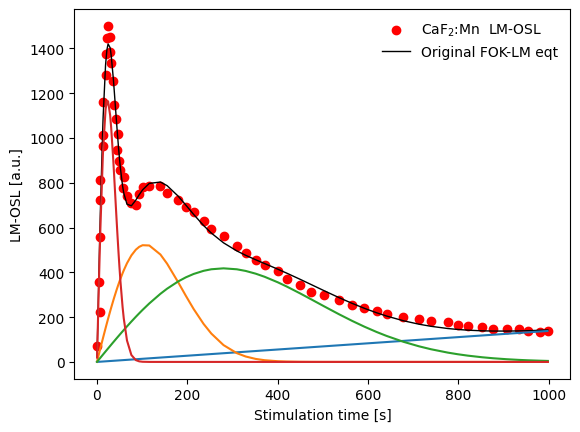

FOM= 5.2  %
+----------+----------+---------+----------+----------+
| N (a.u.) | dN (a.u) | tau (s) | dtau (s) | Area [%] |
+----------+----------+---------+----------+----------+
|  7999.8  |  497.8   |  11.58  |   1.29   |   24.9   |
|  2446.2  |  313.5   |  79.06  |   7.63   |   24.8   |
| 82081.2  |  1753.6  |   0.55  |   0.02   |   43.4   |
|          |          |         |          |  bgd=7%  |
+----------+----------+---------+----------+----------+


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
import requests

# read data file from GitHub
url='https://github.com/vpagonis/EURADOS-2023/raw/main/CaF2LMOSL.TXT'

response = requests.get(url)
a = response.text
b = np.array(list(map(float,a.strip("[]").split())))
data = b.reshape(-1,2)

# normalize the data
x_data,y_data = data[:, 0], data[:, 1] 

# define FOK-LM Bulur equation (first order kinetics)
def LM(x,N,tau):
    u=np.abs(N)*(x/P)*(np.exp(-(x**2.0)\
    /(2*P*abs(tau))))
    return u

# function to add the FOK-LM components
def total_FOKLM(x, *inis): 
    u=np.array([0 for i in range(len(x_data))])
    Ns, taus =    inis[0:nPks], inis[nPks:2*nPks]
    for i in range(nPks):        
        u=u+LM(x,Ns[i],taus[i])
    u=u+bgd*x/P
    return u

# nPks is the number of components
nPks= 3 

# P=maximum of time scale
P=int(max(x_data))
t=np.linspace(0,P,P)

# initial values of parameters, with NO lower and upper bounds
inis=[1400,1,800,.1,500,.01]
bgd=y_data[-1]

# find and plot best fit to the data
params,cov =optimize.curve_fit(total_FOKLM,x_data,\
y_data,p0=inis)
params, cov = optimize.curve_fit(total_FOKLM,\
x_data,y_data,p0=inis,maxfev=10000)   
plt.scatter(x_data, y_data,c='r',label=r'CaF$_2$:Mn  LM-OSL')
plt.plot(x_data, total_FOKLM(x_data, 
 *params),c='black',label='Original FOK-LM eqt',linewidth=1)

# plot linearly increasing background for LM-signal
plt.plot(t,bgd*t/P)

# Find total area and % contribution of each component to area
totalArea=sum(total_FOKLM(x_data,  *params))
sums,pc=[0]*nPks, [0]*nPks
for i in range(0,nPks): 
    FOKLMi=LM(x_data, params[i],params[nPks+i])
    sums[i]=np.sum(FOKLMi)
    plt.plot(x_data,FOKLMi)

for j in range(nPks):
    pc[j]=round(100*sums[j]/totalArea,1) 
pcbgd=round(100*sum(bgd*x_data/P)/totalArea)

leg = plt.legend()
leg.get_frame().set_linewidth(0.0)  
plt.ylabel('LM-OSL [a.u.]')
plt.xlabel(r'Stimulation time [s]')
plt.show()

# find residuals and FOM
res=total_FOKLM(x_data, *params)-y_data
FOM=round(100*np.sum(abs(res))/np.sum(y_data),1)
print('FOM=',FOM,' %')

# evaluate parameters and their errors
Ns=[round(x,1) for x in params[0:nPks]]
taus=[round(x,2) for x in params[nPks:2*nPks]] 
dN=[round(np.sqrt(cov[x][x]),1) for x in range(3)]
dtaus=[round(np.sqrt(cov[x][x]),2) for x in range(3,6)]

# print all parameters and errors in a Table
myTable = PrettyTable([ "N (a.u.)","dN (a.u)",\
'tau (s)',"dtau (s)","Area [%]"]) 
for j in range(nPks):
    myTable.add_row([Ns[j],dN[j],taus[j],dtaus[j],pc[j]])
myTable.add_row(['','','','','bgd='+str(pcbgd)+'%'])
print(myTable)

# [Return to EURADOS website](https://blog.mcdaniel.edu/vasilispagonis/python-codes-for-eurados-2023/)